In [72]:
import pyabf
#load ABF file: should give overview of all the channels 
abf = pyabf.ABF('C:\\Users\\Hannah\\Documents\\MATLAB\\test_analysis\\2026_01_27_0007\\2026_01_27_0007_truncated.abf')
print(abf)

ABF (v2.6) with 6 channels (mV, pA, V, V, V, V), sampled at 20.0 kHz, containing 1 sweep, having no tags, with a total length of 4.37 minutes, recorded with protocol "DrJoes_Gapfree_Ball".


In [73]:
sampling_rate_ephys = 20000
sampling_rate_treadmill = 50
sampling_rate_camera = 150

In [74]:
abf.setSweep(0)

In [75]:
print(abf.headerText)


ABF Class Methods
abf.getAllXs()
abf.getAllYs()
abf.launchInClampFit()
abf.saveABF1()
abf.setSweep()
abf.sweepD()

ABF Class Variables
abfDateTime = 2026-01-27 12:52:56.656000
abfDateTimeString = 2026-01-27T12:52:56.656
abfFileComment =
abfFilePath = C:\Users\Hannah\Documents\MATLAB\test_analysis\2026_01_27_0007\2026_01_27_0007_truncated.abf
abfFolderPath = C:\Users\Hannah\Documents\MATLAB\test_analysis\2026_01_27_0007
abfID = 2026_01_27_0007_truncated
abfVersion = {'major': 2, 'minor': 6, 'bugfix': 0, 'build': 0}
abfVersionString = 2.6.0.0
adcNames = ['IN 0', 'IN 1', 'Pressure', 'yVel', 'xVel', 'zVel']
adcUnits = ['mV', 'pA', 'V', 'V', 'V', 'V']
channelCount = 6
channelList = [0, 1, 2, 3, 4, 5]
creator = Clampex 11.2.0.59
creatorVersion = {'major': 11, 'minor': 2, 'bugfix': 0, 'build': 59}
creatorVersionString = 11.2.0.59
dacNames = ['Cmd 0', 'Cmd 1', 'Cmd 2', 'Cmd 3', 'Cmd 4', 'Cmd 5']
dacUnits = ['mV', 'mV', 'V', 'mV', 'mV', 'mV']
data = [[   -27.771     -27.5879    -27.71   ...   

In [76]:
import numpy as np
n_frames_ephys = abf.sweepPointCount
#counts the number of data points in the sweep
print(n_frames_ephys)
n_frames_treadmill = round(n_frames_ephys/ (sampling_rate_ephys/sampling_rate_treadmill))
n_frames_camera = round(n_frames_ephys/ (sampling_rate_ephys/sampling_rate_camera))

5245408


In [77]:
#Detect movement
#get the channels for the treadmill and ephys data - channels may need to be changed depending on whether air puff present or not
t = abf.sweepX

ephys = abf.data[0, :]
x_vel = abf.data[3, :]
y_vel = abf.data[4, :]
z_vel = abf.data[5, :]

In [78]:
from process_treadmill_data import process_data

#uses the function from process_treadmill_data script to give xy_speed and z_speed
xy_speed, z_speed = process_data(x_vel, y_vel, z_vel)
print(xy_speed)
print(z_speed)

[0.6492 0.6339 0.5693 ... 0.0442 0.0445 0.0441]
[16.6752 17.5396 16.5814 ...  0.3817  0.3882  0.9138]


In [79]:
#sets threshold values for movement: 

xy_speed_thresh = 0.7 #mm/s
z_speed_thresh = 10 # deg/s

xy_movement = xy_speed > xy_speed_thresh
z_movement = z_speed > z_speed_thresh

#any time speeds exceed threshold, gives a 1. If not, gives a zero (creates a variable called movement)
movement = ((xy_speed > xy_speed_thresh) | (z_speed > z_speed_thresh)).astype(float)
print(movement)

[1. 1. 1. ... 0. 0. 0.]


In [80]:
#Fill short gaps
from binary_replace_filter import binary_replace
#this removes all the short gaps in movement and replaces with a 1 instead 
movement = binary_replace(movement)

<function matplotlib.pyplot.show(close=None, block=None)>

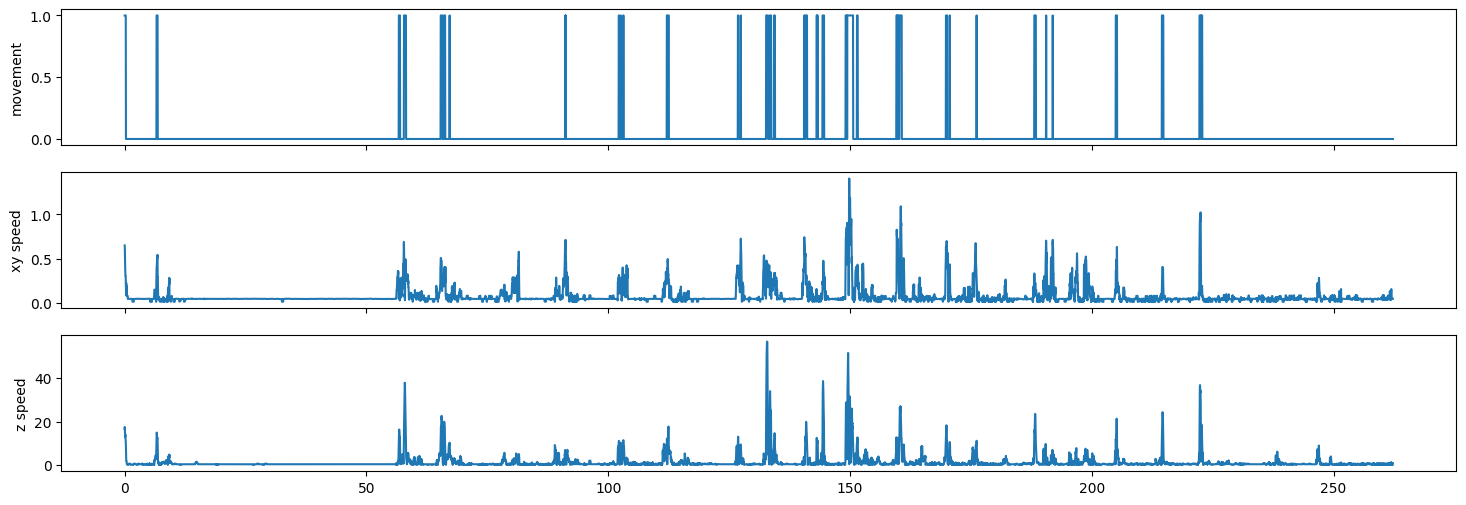

In [81]:
#plot the movement over time compared to the xy_speed and z_speed
import seaborn as sns
import matplotlib.pyplot as plt

n = len(movement)
t = np.arange(n)/sampling_rate_treadmill

fig, axes = plt.subplots(3,1, sharex=True, figsize = (18,6))
sns.lineplot(x = t, y=movement, ax=axes[0])
sns.lineplot(x = t, y=xy_speed, ax=axes[1])
sns.lineplot(x = t, y=z_speed, ax=axes[2])

axes[0].set_ylabel('movement')
axes[1].set_ylabel('xy speed')
axes[2].set_ylabel('z speed')


plt.tight_layout
plt.show



In [82]:
from binary_hysteresis_filter import binary_hysteresis

#apply hysteresis filter to add shorter runs (<= win size) to the previous run 
movement_filtered = binary_hysteresis(movement)
print(movement_filtered)

[0 0 0 ... 0 0 0]


In [83]:
from scipy.interpolate import interp1d
#upsample movement data to match ephys data

upsampling_factor = (sampling_rate_ephys/sampling_rate_treadmill)
n = np.arange(len(movement)) # original indices of movement
nq = np.linspace(0, len(movement)-1, int(len(movement)* upsampling_factor)) # new upsampled indices
f = interp1d(n, movement, kind='nearest')

movement_upsampled = f(nq)


In [84]:
#use the binary replace and hysteresis filter again on upsampled data
movement_upsampled = binary_replace(movement_upsampled)
movement_upsampled = binary_hysteresis(movement_upsampled)

In [85]:
#save movement data
import pandas as pd
np.shape(movement_upsampled)
#convert first to a pandas dataframe
df = pd.DataFrame(movement_upsampled,index=movement_upsampled[:])
df.to_csv('C:\\Users\\Hannah\\Documents\\MATLAB\\test_analysis\\2026_01_27_0007\\movement_upsampled.csv', index=False)
print(df)

    0
1   1
1   1
1   1
1   1
1   1
.. ..
0   0
0   0
0   0
0   0
0   0

[5245600 rows x 1 columns]


In [86]:
# define moving and stationary
moving = movement_upsampled == 1
stationary = movement_upsampled == 0

In [87]:
spike_idx = pd.read_csv("C:\\Users\\Hannah\\Documents\\MATLAB\\test_analysis\\2026_01_27_0007\\2026_01_27_0007_spikes.csv")
spike_binary = np.zeros(len(movement))
spike_binary[spike_idx.astype(int)] = 1
spike_binary[spike_idx.astype(int)-1] = 1

In [88]:
# Load full movement data
movement_upsampled = pd.read_csv("C:\\Users\\Hannah\\Documents\\MATLAB\\test_analysis\\2026_01_27_0007\\movement_upsampled.csv", header=None).values.flatten()
print(len(movement_upsampled))  # should be 6508800

# Load spike indices for full recording
spike_idx = pd.read_csv("C:\\Users\\Hannah\\Documents\\MATLAB\\test_analysis\\2026_01_27_0007\\2026_01_27_0007_spikes.csv", header=None).values.flatten()

# Spike binary for full length
spike_binary = np.zeros(len(movement_upsampled))
spike_binary[spike_idx.astype(int)-1] = 1  # subtract 1 if MATLAB indexing

print(len(spike_binary))  # should be 6508800

5245601
5245601


In [89]:
#bin into firing rate

sampling_rate_ephys = 20000
bin_size = 0.5  
samples_per_bin = int(bin_size*sampling_rate_ephys)

spike_samples = (spike_idx*sampling_rate_ephys).astype(int) #converts seconds to sample index
spike_samples = spike_samples[spike_samples < len(movement_upsampled)]
spike_binary = np.zeros(len(movement_upsampled))
spike_binary[spike_samples] = 1

n_bins = len(spike_binary) // samples_per_bin
spike_binned = spike_binary[:n_bins*samples_per_bin].reshape(n_bins, samples_per_bin)
movement_binned = movement_upsampled[:n_bins*samples_per_bin].reshape(n_bins, samples_per_bin)

firing_rate = spike_binned.sum(axis=1)/bin_size
movement_fraction = movement_binned.mean(axis=1)

# classify bins
moving_bins = movement_fraction > 0.1
stationary_bins = movement_fraction <= 0.1

mean_fr_moving = firing_rate[moving_bins].mean()
mean_fr_stationary = firing_rate[stationary_bins].mean()

print("Mean firing rate during movement:", mean_fr_moving)
print("Mean firing rate during stationary:", mean_fr_stationary)

Mean firing rate during movement: 8.923076923076923
Mean firing rate during stationary: 9.002061855670103


In [127]:
from scipy.stats import wilcoxon

stat, p = wilcoxon(mean_fr_moving, mean_fr_stationary)
print("Wilcoxon test p-value:", p)

Wilcoxon test p-value: 1.0


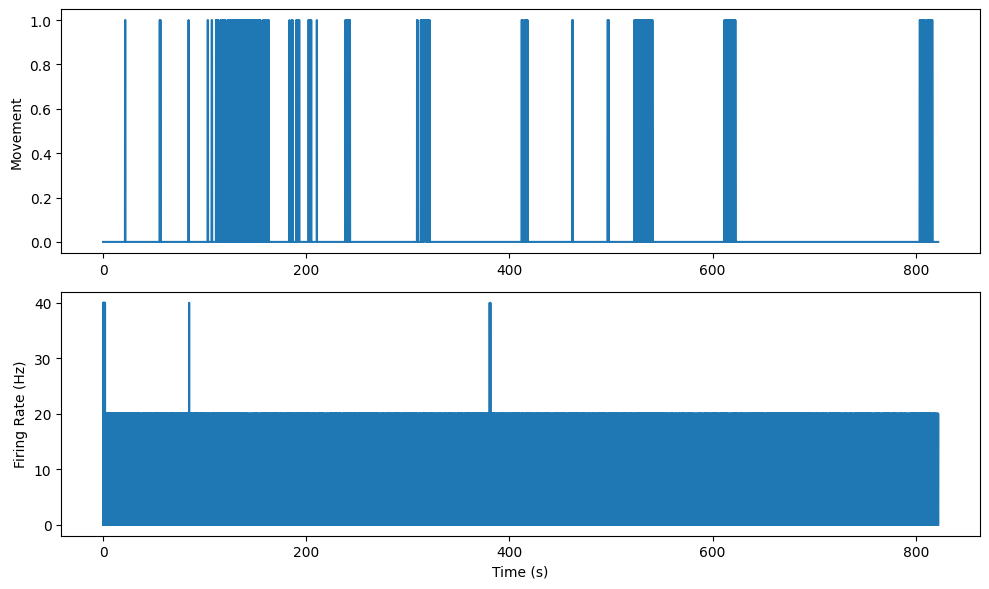

In [128]:
import matplotlib.pyplot as plt

t = np.arange(n_bins) * bin_size

plt.figure(figsize=(10,6))

plt.subplot(2,1,1)
plt.plot(t, moving_bins)
plt.ylabel("Movement")

plt.subplot(2,1,2)
plt.plot(t, firing_rate)
plt.ylabel("Firing Rate (Hz)")
plt.xlabel("Time (s)")

plt.tight_layout()
plt.show()

In [129]:
# movement_upsampled is 0/1
movement_diff = np.diff(movement_upsampled, prepend=0)
movement_onsets = np.where(movement_diff == 1)[0]  # indices where movement starts

In [130]:
window_sec = 1
window_samples = int(window_sec * sampling_rate_ephys)

spike_counts = []

for onset in movement_onsets:
    end_idx = min(onset + window_samples, len(spike_binary))
    spike_counts.append(spike_binary[onset:end_idx].sum())

spike_counts = np.array(spike_counts)


In [131]:
spike_counts = []

for onset in movement_onsets:
    end_idx = min(onset + window_samples, len(spike_binary))
    spike_counts.append(spike_binary[onset:end_idx].sum())

spike_counts = np.array(spike_counts)

In [132]:
firing_rate_onset = spike_counts / window_sec  # spikes/sec

In [133]:
# pick same-length windows before movement
baseline_counts = []

baseline_window_samples = window_samples
for onset in movement_onsets:
    start_idx = max(onset - baseline_window_samples, 0)
    baseline_counts.append(spike_binary[start_idx:onset].sum())

baseline_counts = np.array(baseline_counts)
baseline_rate = baseline_counts / window_sec


In [134]:
from scipy.stats import wilcoxon

stat, p = wilcoxon(firing_rate_onset, baseline_rate)
print("Wilcoxon test p-value:", p)

Wilcoxon test p-value: 0.30715568977941043


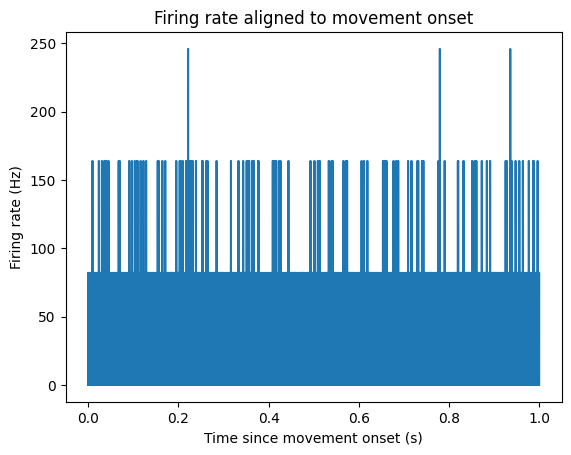

In [135]:
import matplotlib.pyplot as plt

time_bins = np.arange(0, window_samples) / sampling_rate_ephys  # in seconds
psth = np.zeros(window_samples)

for onset in movement_onsets:
    end_idx = min(onset + window_samples, len(spike_binary))
    psth[:end_idx-onset] += spike_binary[onset:end_idx]

psth /= len(movement_onsets)  # average across all bouts
psth = psth * sampling_rate_ephys  # convert to spikes/sec

plt.plot(time_bins, psth)
plt.xlabel("Time since movement onset (s)")
plt.ylabel("Firing rate (Hz)")
plt.title("Firing rate aligned to movement onset")
plt.show()


In [136]:
#comparing spike rate to speed
from scipy.signal import resample

# Upsample xy_speed to match spike_binary length
xy_speed_upsampled = resample(xy_speed, len(spike_binary))
z_speed_upsampled = resample(z_speed, len(spike_binary))


In [137]:
xy_speed_binned = xy_speed_upsampled[:n_bins*samples_per_bin].reshape(n_bins, samples_per_bin).mean(axis=1)
z_speed_binned = z_speed_upsampled[:n_bins*samples_per_bin].reshape(n_bins, samples_per_bin).mean(axis=1)

In [138]:
from scipy.stats import pearsonr

r_xy, p_xy = pearsonr(firing_rate, xy_speed_binned)
r_z, p_z = pearsonr(firing_rate, z_speed_binned)

print(f"XY speed correlation: r = {r_xy:.3f}, p = {p_xy:.5f}")
print(f"Z speed correlation: r = {r_z:.3f}, p = {p_z:.5f}")

XY speed correlation: r = 0.015, p = 0.06193
Z speed correlation: r = 0.013, p = 0.09950


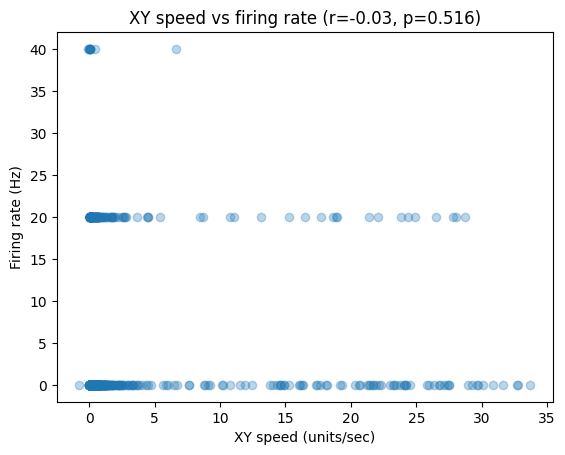

In [127]:

plt.scatter(xy_speed_binned, firing_rate, alpha=0.3)
plt.xlabel("XY speed (units/sec)")
plt.ylabel("Firing rate (Hz)")
plt.title(f"XY speed vs firing rate (r={r_xy:.2f}, p={p_xy:.3f})")
plt.show()